https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
path = '/Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/all/'

items = pd.read_csv(path+'items.csv')
item_categories = pd.read_csv(path+'item_categories.csv')
shops = pd.read_csv(path+'shops.csv')
sales_train = pd.read_csv(path+'sales_train.csv')
test = pd.read_csv(path+'test.csv')

# Format 'date' to datetime
sales_train['date'] = pd.to_datetime(sales_train['date'],format='%d.%m.%Y')

# Add item_category_id to sales_train
sales_train = pd.merge(sales_train,items[['item_id','item_category_id']],on='item_id',how='left').sort_values(by='item_id')

#add new columns: years, month, Y_M
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train_year = sales_train['date'].dt.year.astype('string')
sales_train_month = sales_train['date'].dt.month.astype('string')
sales_train['Y_M'] = sales_train_year+'_'+sales_train_month

#split by year
sales_2013 = sales_train[sales_train['year']==2013]
sales_2014 = sales_train[sales_train['year']==2014]
sales_2015 = sales_train[sales_train['year']==2015]

In [4]:
############# Some things #########################

#columns to keep
#col_to_keep = ['shop_id','item_id','item_price','item_category_id','item_cnt_day']
col_to_keep = ['shop_id','item_id','item_category_id','item_cnt_day']

groupby_list = ['shop_id','item_id']

#agg_dict = {'item_price':'mean','item_category_id':'mean','item_cnt_day':'sum'}
agg_dict = {'item_category_id':'mean','item_cnt_day':'sum'}
agg_targ = {'item_cnt_day':'sum'}

col_targets=['shop_item_cnt_month',
             'shop_cnt_month',
             'item_cnt_month',
             'shop_item_cnt_month_diff(0-1)',
             'shop_cnt_month_diff(0-1)',
             'item_cnt_month_diff(0-1)']

####################################################

In [5]:
########### switches ########

saveplots=True
saveName='Oct10-2018_lag10_diff1_adhoc0p25'
createSubmit = True

#feature options
lag_length = 10
diff = True
diffRel = False
item_cat_count_feat= False

target = ['shop_item_cnt_month_diff(0-1)']
##############################

# create train/val/test set

In [6]:
### training set : 11-2013 with lag features 

x_train = sales_2013[sales_2013['month']==11]
x_train = x_train[col_to_keep]

#Target features:
#agg shop_item 
x_train_shop_item = x_train.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month'})
#agg shop 
x_train_shop = x_train[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month'})
#agg item 
x_train_item = x_train[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month'})
#agg item_cat 
if(item_cat_count_feat):x_train_itemcat = x_train[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month'})

#merge
x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop,on=['shop_id'],how='left')
x_train_shop_item = pd.merge(x_train_shop_item,x_train_item,on=['item_id'],how='left')
if(item_cat_count_feat):x_train_shop_item = pd.merge(x_train_shop_item,x_train_itemcat,on=['item_category_id'],how='left')


#introduce lag features 10 months behind.
for i in xrange(1,lag_length+1):
    x_train_lag = sales_2013[sales_2013['month']==(11-i)]
    x_train_lag = x_train_lag[col_to_keep]

    #agg shop_item 
    x_train_shop_item_lag = x_train_lag.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_'+str(i)})
    x_train_shop_item_lag.drop(columns=['item_category_id'],inplace=True)
    #agg shop 
    x_train_shop_lag = x_train_lag[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_'+str(i)})
    #agg item 
    x_train_item_lag = x_train_lag[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_'+str(i)})
    #agg item_cat 
    if(item_cat_count_feat):x_train_itemcat_lag = x_train_lag[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_'+str(i)})

    #merge
    x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop_item_lag,on=['shop_id','item_id'],how='left')
    x_train_shop_item = pd.merge(x_train_shop_item,x_train_shop_lag,on=['shop_id'],how='left')
    x_train_shop_item = pd.merge(x_train_shop_item,x_train_item_lag,on=['item_id'],how='left')
    if(item_cat_count_feat):x_train_shop_item = pd.merge(x_train_shop_item,x_train_itemcat_lag,on=['item_category_id'],how='left')
    
    #diffs
    for col in ['shop_item','shop','item','item_cat']:
        if(not item_cat_count_feat and col=='item_cat'): continue #skip item_cat if this feat is not turned on 

        if i==1:
            if(diff):x_train_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] = x_train_shop_item[col+'_cnt_month'] - x_train_shop_item[col+'_cnt_month_lag_'+str(i)]   
        if i>=2:
            if(diff):x_train_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] = x_train_shop_item[col+'_cnt_month_lag_'+str(i-1)] - x_train_shop_item[col+'_cnt_month_lag_'+str(i)]   
        
        if(diffRel):x_train_shop_item[col+'_cnt_month_({}-{})/{}'.format(str(i-1),str(i),str(i))] = x_train_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] / (x_train_shop_item[col+'_cnt_month_lag_'+str(i)]+1e-7)   
                   
#pick (meta)target            
y_train = x_train_shop_item['shop_item_cnt_month']

#remove targets(s):
x_train = x_train_shop_item.drop(columns=col_targets)

x_train = x_train.fillna(0)

print 'x_train.shape :',x_train.shape
x_train.head()

y_train.head()

### validation set: 11-2014 with lag features

x_val = sales_2014[sales_2014['month']==11]
x_val = x_val[col_to_keep]

#agg shop_item 
x_val_shop_item = x_val.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month'})
#agg shop 
x_val_shop = x_val[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month'})
#agg item 
x_val_item = x_val[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month'})
#agg item_cat 
if(item_cat_count_feat):x_val_itemcat = x_val[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month'})

#merge
x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop,on=['shop_id'],how='left')
x_val_shop_item = pd.merge(x_val_shop_item,x_val_item,on=['item_id'],how='left')
if(item_cat_count_feat):x_val_shop_item = pd.merge(x_val_shop_item,x_val_itemcat,on=['item_category_id'],how='left')

    
#introduce lag features
for i in xrange(1,lag_length+1):
    x_val_lag = sales_2014[sales_2014['month']==(11-i)]
    x_val_lag = x_val_lag[col_to_keep]

    #agg shop_item 
    x_val_shop_item_lag = x_val_lag.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_'+str(i)})
    x_val_shop_item_lag.drop(columns=['item_category_id'],inplace=True)
    #agg shop 
    x_val_shop_lag = x_val_lag[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_'+str(i)})
    #agg item 
    x_val_item_lag = x_val_lag[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_'+str(i)})
    #agg item_cat 
    if(item_cat_count_feat):x_val_itemcat_lag = x_val_lag[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_'+str(i)})

    #merge
    x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop_item_lag,on=['shop_id','item_id'],how='left')
    x_val_shop_item = pd.merge(x_val_shop_item,x_val_shop_lag,on=['shop_id'],how='left')
    x_val_shop_item = pd.merge(x_val_shop_item,x_val_item_lag,on=['item_id'],how='left')
    if(item_cat_count_feat):x_val_shop_item = pd.merge(x_val_shop_item,x_val_itemcat_lag,on=['item_category_id'],how='left')
    
    #diffs
    for col in ['shop_item','shop','item','item_cat']:
        if(not item_cat_count_feat and col=='item_cat'): continue #skip item_cat if this feat is not turned on 

        if i==1: 
            if(diff):x_val_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] = x_val_shop_item[col+'_cnt_month'] - x_val_shop_item[col+'_cnt_month_lag_'+str(i)]   
        if i>=2: 
            if(diff):x_val_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] = x_val_shop_item[col+'_cnt_month_lag_'+str(i-1)] - x_val_shop_item[col+'_cnt_month_lag_'+str(i)]   

        if(diffRel):x_val_shop_item[col+'_cnt_month_({}-{})/{}'.format(str(i-1),str(i),str(i))] = x_val_shop_item[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] / (x_val_shop_item[col+'_cnt_month_lag_'+str(i)]+1e-7)   


#pick (meta)target            
y_val = x_val_shop_item['shop_item_cnt_month']

#remove targets(s):
x_val = x_val_shop_item.drop(columns=col_targets)

x_val = x_val.fillna(0)

print 'x_val.shape :',x_val.shape
x_val.head()

y_val.head()

### test set: 11-2015 with lag features 

x_test = test.sort_values(by=groupby_list)

#add item_category_id.
x_test = pd.merge(x_test,items[['item_id','item_category_id']],on='item_id',how='left')

#introduce lag features
for i in xrange(1,lag_length+1):
    x_test_lag = sales_2015[sales_2015['month']==(11-i)]
    x_test_lag = x_test_lag[col_to_keep]

    #agg shop_item 
    x_test_shop_item_lag = x_test_lag.groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_'+str(i)})
    x_test_shop_item_lag.drop(columns=['item_category_id'],inplace=True)
    #agg shop 
    x_test_shop_lag = x_test_lag[['shop_id','item_cnt_day']].groupby(['shop_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'shop_cnt_month_lag_'+str(i)})
    #agg item 
    x_test_item_lag = x_test_lag[['item_id','item_cnt_day']].groupby(['item_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cnt_month_lag_'+str(i)})
    #agg item_cat 
    if(item_cat_count_feat):x_test_itemcat_lag = x_test_lag[['item_category_id','item_cnt_day']].groupby(['item_category_id'],as_index=False).agg(agg_targ).rename(columns={'item_cnt_day':'item_cat_cnt_month_lag_'+str(i)})

    #merge
    x_test = pd.merge(x_test,x_test_shop_item_lag,on=['shop_id','item_id'],how='left')
    x_test = pd.merge(x_test,x_test_shop_lag,on=['shop_id'],how='left')
    x_test = pd.merge(x_test,x_test_item_lag,on=['item_id'],how='left')
    if(item_cat_count_feat):x_test = pd.merge(x_test,x_test_itemcat_lag,on=['item_category_id'],how='left')
    
    #diffs
    for col in ['shop_item','shop','item','item_cat']:
        if(not item_cat_count_feat and col=='item_cat'): continue #skip item_cat if this feat is not turned on 
        if i>=2:  
            if(diff):x_test[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] = x_test[col+'_cnt_month_lag_'+str(i-1)] - x_test[col+'_cnt_month_lag_'+str(i)]   
            if(diffRel):x_test[col+'_cnt_month_({}-{})/{}'.format(str(i-1),str(i),str(i))] = x_test[col+'_cnt_month_diff({}-{})'.format(str(i-1),str(i))] / (x_test[col+'_cnt_month_lag_'+str(i)]+1e-7)   


x_test = x_test.fillna(0)
x_test.drop(columns=['ID'],inplace=True)

print 'x_test.shape :',x_test.shape
x_test.head()

x_train.shape : (51460, 60)
x_val.shape : (45755, 60)
x_test.shape : (214200, 60)


,shop_id,item_id,item_category_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,shop_item_cnt_month_lag_2,shop_cnt_month_lag_2,item_cnt_month_lag_2,shop_item_cnt_month_diff(1-2),...,item_cnt_month_lag_9,shop_item_cnt_month_diff(8-9),shop_cnt_month_diff(8-9),item_cnt_month_diff(8-9),shop_item_cnt_month_lag_10,shop_cnt_month_lag_10,item_cnt_month_lag_10,shop_item_cnt_month_diff(9-10),shop_cnt_month_diff(9-10),item_cnt_month_diff(9-10)
0,2,30,40,0.0,727.0,1.0,0.0,822.0,3.0,0.0,...,14.0,0.0,-145.0,-9.0,0.0,987.0,14.0,0.0,-80.0,0.0
1,2,31,37,1.0,727.0,18.0,0.0,822.0,9.0,0.0,...,13.0,0.0,-145.0,-1.0,0.0,987.0,25.0,0.0,-80.0,-12.0
2,2,32,40,0.0,727.0,22.0,0.0,822.0,19.0,0.0,...,32.0,0.0,-145.0,8.0,0.0,987.0,42.0,0.0,-80.0,-10.0
3,2,33,37,0.0,727.0,16.0,1.0,822.0,16.0,0.0,...,26.0,0.0,-145.0,-6.0,0.0,987.0,19.0,0.0,-80.0,7.0
4,2,38,41,0.0,727.0,0.0,0.0,822.0,2.0,0.0,...,4.0,0.0,-145.0,-3.0,0.0,987.0,7.0,0.0,-80.0,-3.0


In [7]:
#combine 2013+2014
x_train  = pd.concat([x_train, x_val], ignore_index=True)
y_train  = pd.concat([y_train, y_val], ignore_index=True)
x_train.shape

(97215, 60)

# Model training

In [8]:
## Linear Regressoin ##
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# lr = LinearRegression()
# lr.fit(x_train.values, y_train)

# pred_lr = lr.predict(x_train.values)
# print('Training R-squared for linreg is %f' % r2_score(y_train, pred_lr))

# pred_lr_val = lr.predict(x_val.values)
# print('Validation R-squared for linreg is %f' % r2_score(y_val, pred_lr_val))

# last_month_shop_item_cnt_month = sales_2015[sales_2015['month']==(10)].groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
# last_month_shop_item_cnt_month = last_month_shop_item_cnt_month[['shop_id','item_id','shop_item_cnt_month_lag_1']].head()
# df_temp = pd.merge(x_test[['shop_id','item_id']],last_month_shop_item_cnt_month,on=('shop_id','item_id'),how='left')
# df_temp.fillna(0,inplace=True)
# df_temp.head()

# df_pred_lr = pd.DataFrame(pred_lr,columns=['y_pred_residual'])
# df_pred_lr.head()

# df_pred_lr['y_pred'] = df_temp['shop_item_cnt_month_lag_1'] + df_pred_lr['y_pred_residual']
# df_pred_lr.head()

# pred_lr_submit = df_pred_lr['y_pred'].values
# print pred_lr_submit

# # True target values are clipped into [0,20] range.
# pred_lr_submit = np.clip(pred_lr_submit,0,20)
# print pred_lr_submit

# #import sys
# #WorkDir = '/Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/'
# #sys.path.insert(0, WorkDir)
# import utility.utility as ut

# y_test = pd.DataFrame(pred_lr_submit,columns=['item_cnt_month'])
# #saveName='constant_0p38'
# #saveplots=True

# total_item_cnt_2013 = sales_2013.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
# total_item_cnt_2014 = sales_2014.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
# total_item_cnt_2015 = sales_2015.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
# yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

# ut.plotYearly(yearlySales,y_test,saveName,saveplots)
# ut.plotYearly_v2(yearlySales,y_test,saveName,saveplots)
# ut.plotResidual(yearlySales,y_test,saveName,saveplots)

In [9]:
### Boosted Decision Tree (lightgbm)

import lightgbm as lgb
from sklearn.metrics import r2_score

evals_result={}

lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_test = lgb.Dataset(x_val, label=y_val)

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1,
              }

num_boost_round = 4000
verbose_eval = num_boost_round/20
model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=num_boost_round,
                  evals_result=evals_result,
                  early_stopping_rounds=1000,
                  verbose_eval=verbose_eval)

#print 'evals_result = ',evals_result

Training until validation scores don't improve for 1000 rounds.
[200]	train's rmse: 7.40558	eval's rmse: 7.89133
[400]	train's rmse: 6.98149	eval's rmse: 7.48579
[600]	train's rmse: 6.70439	eval's rmse: 7.20811
[800]	train's rmse: 6.49635	eval's rmse: 6.99208
[1000]	train's rmse: 6.31491	eval's rmse: 6.79671
[1200]	train's rmse: 6.13951	eval's rmse: 6.6101
[1400]	train's rmse: 6.00208	eval's rmse: 6.46135
[1600]	train's rmse: 5.86535	eval's rmse: 6.30893
[1800]	train's rmse: 5.74976	eval's rmse: 6.17832
[2000]	train's rmse: 5.65703	eval's rmse: 6.07435
[2200]	train's rmse: 5.54385	eval's rmse: 5.94873
[2400]	train's rmse: 5.44138	eval's rmse: 5.84368
[2600]	train's rmse: 5.34137	eval's rmse: 5.73601
[2800]	train's rmse: 5.24096	eval's rmse: 5.61938
[3000]	train's rmse: 5.16261	eval's rmse: 5.53398
[3200]	train's rmse: 5.09366	eval's rmse: 5.45644
[3400]	train's rmse: 5.01695	eval's rmse: 5.36752
[3600]	train's rmse: 4.94394	eval's rmse: 5.28822
[3800]	train's rmse: 4.8714	eval's rmse: 

Plot metrics recorded during training...


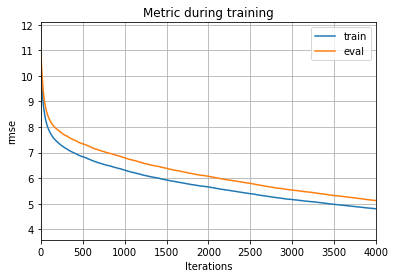

Plot feature importances...


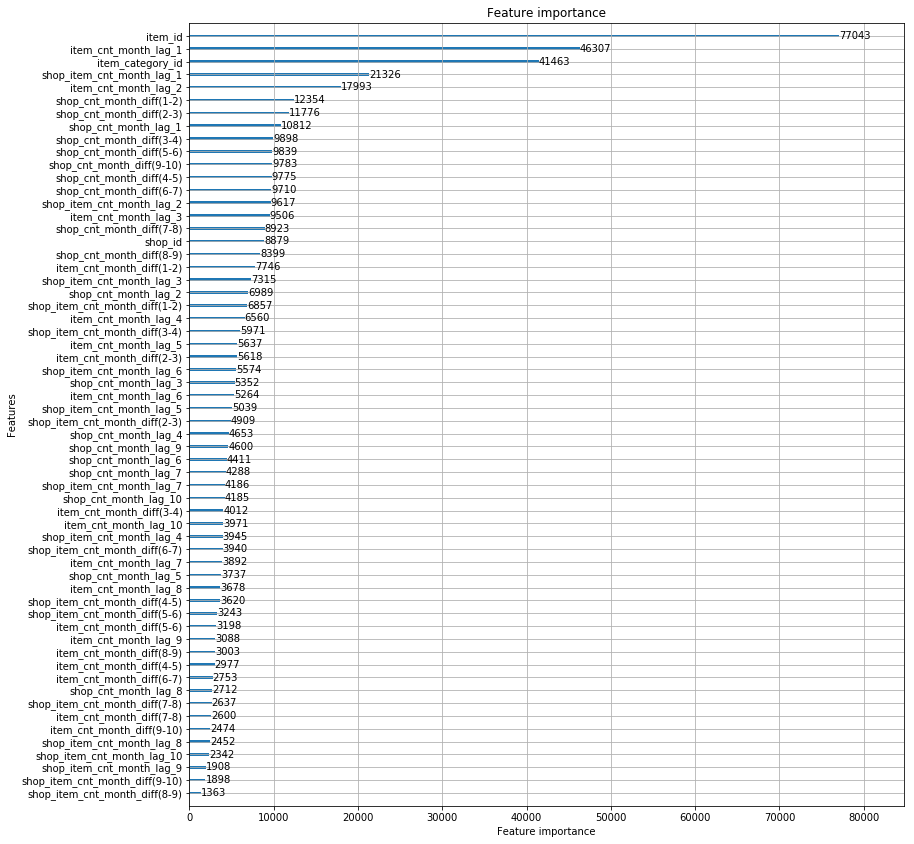

In [10]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig("lgb_plot_metric_"+saveName+".pdf")
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_test.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig("lgb_plot_importance_"+saveName+".pdf")
plt.show()

In [11]:
pred_lgb = model.predict(x_train)
print('Training R-squared for LightGBM is %f' % r2_score(y_train, pred_lgb))

Training R-squared for LightGBM is 0.788236


In [12]:
pred_lgb = model.predict(x_val)
print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

Validation R-squared for LightGBM is 0.781374


# Predict with test data

In [13]:
pred = model.predict(x_test)

In [14]:
print pred.size
print pred

214200
[-0.34029949  0.57801482  0.57092283 ...  1.50100887  1.13663393
  1.38688204]


In [15]:
last_month_shop_item_cnt_month = sales_2015[sales_2015['month']==(10)].groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
last_month_shop_item_cnt_month = last_month_shop_item_cnt_month[['shop_id','item_id','shop_item_cnt_month_lag_1']].head()
df_temp = pd.merge(x_test[['shop_id','item_id']],last_month_shop_item_cnt_month,on=('shop_id','item_id'),how='left')
df_temp.fillna(0,inplace=True)
df_temp.head()

df_pred = pd.DataFrame(pred,columns=['y_pred_residual'])
df_pred.head()

df_pred['y_pred'] = df_temp['shop_item_cnt_month_lag_1'] + df_pred['y_pred_residual']
df_pred.head()

pred_submit = df_pred['y_pred'].values

# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
    
print pred_submit

[0.         1.57801482 0.57092283 ... 1.50100887 1.13663393 1.38688204]


In [16]:
#adhoc scaling
pred_submit = (pred_submit)*0.25 
#pred_submit = np.floor(pred_submit)
print pred_submit

[0.         0.39450371 0.14273071 ... 0.37525222 0.28415848 0.34672051]


# Validation with yearly trend (BDT)

total sales count from Oct10-2018_lag10_diff1_adhoc0p25 prediction: 69502.12980840456
total sales count from contant 0.5 prediction: 107100.0


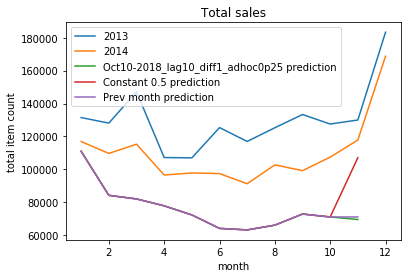

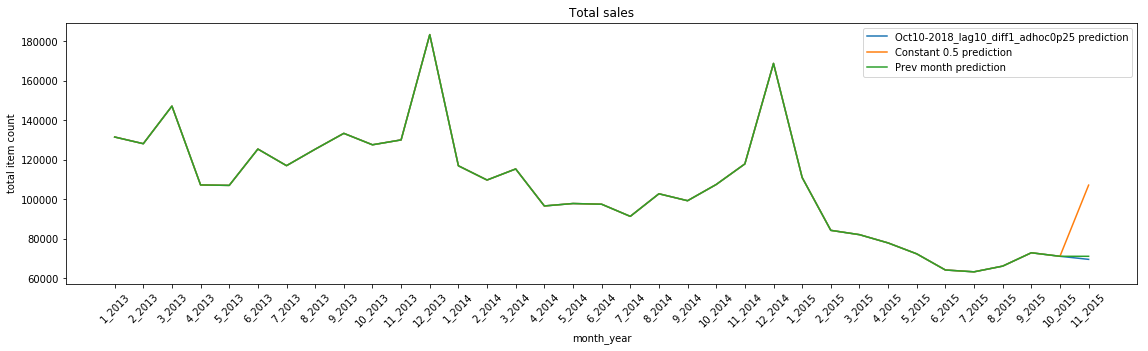

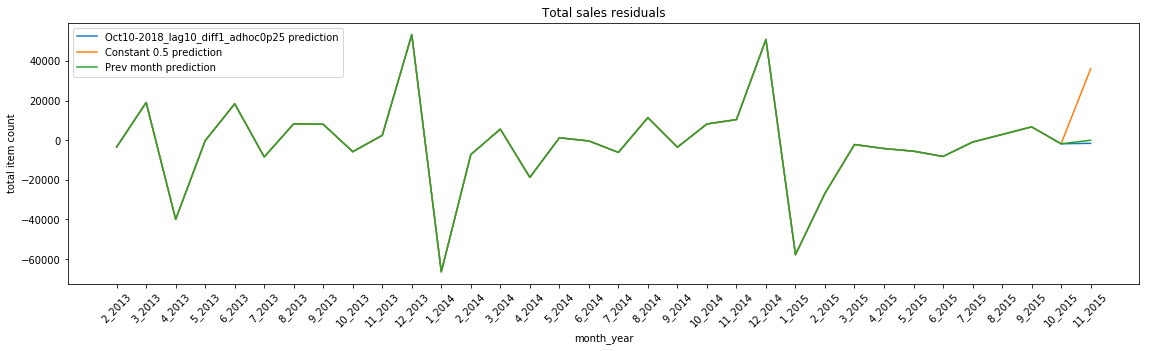

In [17]:
#import sys
#WorkDir = '/Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/'
#sys.path.insert(0, WorkDir)
import utility.utility as ut

y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])
#saveName='constant_0p38'
#saveplots=True

total_item_cnt_2013 = sales_2013.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = sales_2014.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = sales_2015.groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

ut.plotYearly(yearlySales,y_test,saveName,saveplots)
ut.plotYearly_v2(yearlySales,y_test,saveName,saveplots)
ut.plotResidual(yearlySales,y_test,saveName,saveplots)

# Prepare submission file

In [18]:
test_sorted = test.sort_values(by=groupby_list).reset_index(drop=True)
submit = pd.concat([test_sorted,y_test],axis=1)
submit = submit.sort_values(by="ID").reset_index(drop=True)

# sanity check
print 'These numbers below should match:'
print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_month"].values[0]

submit = submit[["item_cnt_month"]]
submit.index.name="ID"
submit.head()

submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):submit.to_csv('submit_'+submitName+'.csv')

These numbers below should match:
y_test.iloc[0] = 0.0
submit[submit["ID"]==22987] =  0.0
